#### The aim of this notebook is to highlight all implemented functions during the cemracs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess

rng = np.random.default_rng(42) 

Throughout this notebook, we will consider the following example:

In [2]:
cat data/styphi_fprau_oxygen.yml

species:
    Styphi:
        biomass_name: biomass_iRR1083_metals
        initial_value: 5e-1
        Substrate_Reaction_Map:
            glucarate: EX_glcr_e
            glucose: EX_glc__D_e
            galactose: EX_gal_e
            thiosulfate: EX_tsul_e
            galactarate: EX_galct__D_e
            tetrathionate: EX_tet_e
            nitrate: EX_no3_e
            o2: EX_o2_e
        Output_Reaction_Map:
            {}
        sbml_model: "data/Salmonella_FBA.xml"
    Fprau:
        biomass_name: Biomass
        initial_value: 5e-1
        Substrate_Reaction_Map:
            glucose: EX_D-Glucose_b
            galactose: EX_D-Galactose_b
        Output_Reaction_Map:
            butyrate: EX_Butyrate_b
        sbml_model: "data/Fprau_FBA.xml"
Substrate_metabolites:
    glucarate:
        initial_value: 120
    glucose:
        initial_value: 120
    galactose:
        initial_value: 120
    thiosulfate:
        initial_value: 120
    galactarate:
        initial_value: 120
    

The latter can be encoded into an __experiment:__

In [3]:
from dfba_sampling.experiment import ExperimentSpec

In [4]:
exp = ExperimentSpec(config="data/styphi_fprau_oxygen.yml",
                     networks=["data/Salmonella_FBA.xml", "data/Fprau_FBA.xml"])

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


This will be the cornerstone of the dFBA simulations, and for sampling different configurations.

# 1- dFBA

In [5]:
from dfba_sampling.dFBA import TimeIntegration
from dfba_sampling.vizu import PlotFBA, Plot

Lets modify the initial conditions $y_0$ and run our first dFBA simulation. The order of the
compounds is always the same: substrate metabolites, output metabolites and bacteria.

In [6]:
exp.compound_name

['glucarate',
 'glucose',
 'galactose',
 'thiosulfate',
 'galactarate',
 'tetrathionate',
 'nitrate',
 'o2',
 'butyrate',
 'Styphi',
 'Fprau']

In [7]:
exp.y0 = np.append(rng.uniform(0, 100, len(exp.substrate_metabolites)+len(exp.output_metabolites)),
                   rng.uniform(0, 1, len(exp.species)))
exp.y0[-4] = rng.uniform(0, 3) # select a low concentration of oxygen on purpose.
# present/absent substrate metabolites with probability .85:
# exp.y0[:len(exp.substrate_metabolites)] *= rng.choice(range(2), size=len(exp.substrate_metabolites), p=[.15, .85])

In [8]:
exp.y0

array([77.39560486, 43.88784398, 85.85979199, 69.73680291,  9.41773479,
       97.56223516, 76.1139702 ,  2.78029497, 12.81136327,  0.45038594,
        0.37079802])

Something that should be changed: updating the time of simulation must be done with the nb_timestep
as well, these are the ones over with the simulation will iterate.

In [9]:
exp.time = 11
exp.nb_timestep = 1101

When launched with only `exp` as argument, `TimeIntegration` performs the usual dFBA.

In [10]:
y_fba,flux_fba,constraint_fba=TimeIntegration(exp)

t= 0.0 / 11 hours
t= 1.0 / 11 hours
t= 2.0 / 11 hours
t= 3.0 / 11 hours
t= 4.0 / 11 hours
t= 5.0 / 11 hours
t= 6.0 / 11 hours
t= 7.0 / 11 hours
t= 8.0 / 11 hours
t= 9.0 / 11 hours
t= 10.0 / 11 hours
t= 11.0 / 11 hours


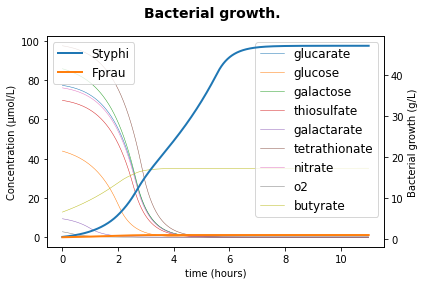

In [11]:
Plot(y_fba, exp)

We can also compute fluxes at a specific constraint point, with `FBA_model_Wrapper`

In [12]:
from dfba_sampling.FBA import FBA_model_Wrapper
from dfba_sampling.dFBA import Constraint_definition

In [13]:
constraint = Constraint_definition(y_fba[1], exp)
print(constraint, constraint.shape)

[[-1.5547564e-03 -5.0000000e+00 -5.0000000e+00 -5.0000000e+00
  -5.0000000e+00 -1.4607355e+00 -5.0000000e+00 -5.0000000e+00]] (1, 8)


Note the shape of the produced `constraint`. This is to ensure compatibility with the fluxes generated by
the metamodel, which can be obtained in batch.

In [14]:
flux = FBA_model_Wrapper(constraint, "Styphi", exp)
print(flux)

(array([-1.55475640e-03, -5.00000000e+00, -5.00000000e+00, -5.00000000e+00,
       -5.00000000e+00, -1.46073550e+00, -5.00000000e+00, -5.00000000e+00,
        0.00000000e+00,  1.27948911e+00,  0.00000000e+00]), 'optimal')


# 2- Sampling different experiments

In [15]:
from dfba_sampling.constraint_sampler import Constraint_Sampler

From this "canonical" experiment, we will create new ones with different initial conditions
and assemble a (constraints ,fluxes) database with specifics that are described in a `sampling_parameters.yml` file

In [16]:
cat data/sampling_parameters.yml

uniform_y0:
    bounds: [0, 100]
    bounds_bact: [0, 1]
    log: True
proba_presence_y0: 0.85
subsampling_ratio: 0.1
perturb:
    sigma: 0.1
    N_perturb: 2
N_y0: 3
random_state: 42
path_to_directories: data/samples_notebook
directories_prefix: sample


Let's create the directory `data/samples_notebook` before sampling the new experiments.

In [17]:
os.makedirs("data/samples_notebook",exist_ok=True)

In [18]:
cs = Constraint_Sampler(exp_config="data/styphi_fprau_oxygen.yml",
                        sample_config="data/sampling_parameters.yml")

So far, `Constraint_Sampler` creates an experiment from a yml file, while in this case it could just have
take the already existing one as argument.

Anyway, let's sample some files and check that they are indeed here.

In [19]:
cs.sample_yaml_files()

In [20]:
cat data/samples_notebook/sample_2/config.yml

Output_metabolites:
  butyrate:
    initial_value: 0
Substrate_metabolites:
  galactarate:
    initial_value: 97
  galactose:
    initial_value: 75
  glucarate:
    initial_value: 0
  glucose:
    initial_value: 63
  nitrate:
    initial_value: 77
  o2:
    initial_value: 0
  tetrathionate:
    initial_value: 89
  thiosulfate:
    initial_value: 35
Time: 10
Timestep: 0.01
intrinsic_flux: -5.0
limit_dt: 0.5
species:
  Fprau:
    Output_Reaction_Map:
      butyrate: EX_Butyrate_b
    Substrate_Reaction_Map:
      galactose: EX_D-Galactose_b
      glucose: EX_D-Glucose_b
    biomass_name: Biomass
    initial_value: '3.2582535813815194e-1'
    sbml_model: data/Fprau_FBA.xml
  Styphi:
    Output_Reaction_Map: {}
    Substrate_Reaction_Map:
      galactarate: EX_galct__D_e
      galactose: EX_gal_e
      glucarate: EX_glcr_e
      glucose: EX_glc__D_e
      nitrate: EX_no3_e
      o2: EX_o2_e
      tetrathionate: EX_tet_e
      thiosulfate: EX_tsul_e
    biomass_name: biomass_iRR1083_metals


3 directories have been created in `data/samples_notebook`, we just need to perform the dFBA with the
corresponding yml files (this can take a few minutes).

In [21]:
for i in range(cs.param['N_y0']):
    subprocess.call([f"python3 -mdfba_sampling -c data/samples_notebook/sample_{i}/config.yml -n data/Salmonella_FBA.xml data/Fprau_FBA.xml -o data/samples_notebook/sample_{i}/"],
                    shell=True)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
t= 0.0 / 10 hours
t= 1.0 / 10 hours
t= 2.0 / 10 hours
t= 3.0 / 10 hours
t= 4.0 / 10 hours
t= 5.0 / 10 hours
t= 6.0 / 10 hours
t= 7.0 / 10 hours
t= 8.0 / 10 hours
t= 9.0 / 10 hours
t= 10.0 / 10 hours


And we can now assemble our database using the generated files `out_constraint.tsv`, `out_FBA_Styphi.tsv` and
`out_FBA_Fprau.tsv`

In [22]:
cs.assemble()

In [23]:
path_to_constraints = "data/samples_notebook/database_constraints.tsv"
path_to_fluxes_styphi = "data/samples_notebook/database_fluxes_Styphi.tsv"
path_to_fluxes_fprau = "data/samples_notebook/database_fluxes_Fprau.tsv"

In [24]:
constraints = pd.read_csv(path_to_constraints, sep="\t")
fluxes_styphi =  pd.read_csv(path_to_fluxes_styphi, sep="\t")
fluxes_fprau = pd.read_csv(path_to_fluxes_fprau, sep="\t")

# 3- Metamodeling

In [25]:
from dfba_sampling.metamodel import Metamodel

Once the training database is created, we can move on to the training of our metamodels.
For speed issues, let's just consider $100$ samples.

In [26]:
n_obs = 100
path_to_fluxes = [path_to_fluxes_styphi, path_to_fluxes_fprau]

mm = [Metamodel(constraints=path_to_constraints,
                      fluxes=path_to_fluxes[i],
                      kernel_type="Matern") for i in range(len(path_to_fluxes))]

Again, we are giving as argument the path to databases, where we could have pass them directly as
argument here. It is also possible to define a new constraint / flux learning set, for instance with
a different number of observations

In [27]:
for i in range(len(path_to_fluxes)):
    mm[i].new_constraintlearningset(path_to_constraints, n_obs=n_obs)
    mm[i].new_fluxlearningset(path_to_fluxes[i], n_obs=n_obs)

In [28]:
print(mm[0].C_learn.shape, mm[1].C_learn.shape)
print(mm[0].Flux_learn.shape, mm[1].Flux_learn.shape)

(100, 8) (100, 8)
(100, 11) (100, 11)


Let's build all the Gram Matrices associated to the data. There is one for each different subset of 
$\{1, \dots, N_{sub}\}$ with $N_{sub} = 8$ being the number of different substrate metabolites,
which means a total of $2^8 - 1 = 255$ Gram matrices, each of size $(100, 100)$. Due to the fact that
the Gram matrix $G_p$ associated to a subset $p$ is only the product of the Gram matrices $G_a$ for $a\in p$, we
really only have to compute from scratch $N_{sub}$ Gram matrices.

In [29]:
mm[0].P_MaxOrder(mm[0].Nsub)
mm[0].GramMatrix()

Generation of the Gram matrix for the subset  [0]


/home/simon/Documents/SVN_GIT/SLIMMEST/python-dfba-sampling/.tox/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


Generation of the Gram matrix for the subset  [1]
Generation of the Gram matrix for the subset  [2]
Generation of the Gram matrix for the subset  [3]
Generation of the Gram matrix for the subset  [4]
Generation of the Gram matrix for the subset  [5]
Generation of the Gram matrix for the subset  [6]
Generation of the Gram matrix for the subset  [7]
Generation of the Gram matrix for the subset  [0 1]
Generation of the Gram matrix for the subset  [0 2]
Generation of the Gram matrix for the subset  [0 3]
Generation of the Gram matrix for the subset  [0 4]
Generation of the Gram matrix for the subset  [0 5]
Generation of the Gram matrix for the subset  [0 6]
Generation of the Gram matrix for the subset  [0 7]
Generation of the Gram matrix for the subset  [1 2]
Generation of the Gram matrix for the subset  [1 3]
Generation of the Gram matrix for the subset  [1 4]
Generation of the Gram matrix for the subset  [1 5]
Generation of the Gram matrix for the subset  [1 6]
Generation of the Gram mat

In [30]:
mm[0].K.shape

(255, 100, 100)

And since the constraint database is the same whether we aim to predict Fprau fluxes or Styphi's, we can simply do:

In [31]:
mm[1].P_MaxOrder(mm[1].Nsub)
mm[1].K = mm[0].K

/home/simon/Documents/SVN_GIT/SLIMMEST/python-dfba-sampling/.tox/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


Finally, we can learn our metamodels. For the purpose of demonstration, we will only perform $10$ iterations
for the training, this will already take a few minutes. Since we are learning $n_{species} \times n_{compounds} = 22$ metamodels.

In [32]:
mu = .05
iter_max = 10
eps_res = 1e-4
learning_rate = 1e-5

for i in range(len(path_to_fluxes)):
    mm[i].learn_metamodel(
            mu=mu,
            iter_max=iter_max,
            eps_res=eps_res,
            flag_print=True,
            learning_rate=learning_rate,
        )

at iteration 000, the 00 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 01 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 02 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 03 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 04 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 05 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 06 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 07 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 08 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 09 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 10 th part has all theta =0 

at iteration 000, the 92 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 93 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 94 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 95 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 96 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 97 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 98 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 99 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 100 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 101 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 102 th part has all theta 

at iteration 000, the 186 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 187 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 188 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 189 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 190 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 191 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 192 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 193 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 194 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 195 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 196 th part has al

at iteration 000, the 23 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 24 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 25 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 26 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 27 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 28 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 29 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 30 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 31 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 32 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 33 th part has all theta =0 

at iteration 000, the 143 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 144 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 145 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 146 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 147 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 148 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 149 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 150 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 151 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 152 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 153 th part has al

at iteration 000, the 239 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 240 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 241 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 242 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 243 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 244 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 245 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 246 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 247 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 248 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 249 th part has al

at iteration 000, the 73 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 74 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 75 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 76 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 77 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 78 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 79 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 80 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 81 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 82 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 83 th part has all theta =0 

at iteration 000, the 172 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 173 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 174 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 175 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 176 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 177 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 178 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 179 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 180 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 181 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 182 th part has al

### iteration 005 /  10 , residual=2.78e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 006 /  10 , residual=2.59e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 007 /  10 , residual=2.43e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 008 /  10 , residual=2.29e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 009 /  10 , residual=2.16e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 010 /  10 , residual=2.05e-01 % of ||Y||_2/sqrt(Nobs)
at iteration 000, the 00 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 01 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 02 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 03 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 04 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 05 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 

at iteration 000, the 103 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 104 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 105 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 106 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 107 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 108 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 109 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 110 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 111 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 112 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 113 th part has al

at iteration 000, the 206 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 207 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 208 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 209 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 210 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 211 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 212 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 213 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 214 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 215 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 216 th part has al

at iteration 000, the 34 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 35 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 36 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 37 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 38 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 39 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 40 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 41 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 42 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 43 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 44 th part has all theta =0 

at iteration 000, the 121 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 122 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 123 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 124 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 125 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 126 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 127 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 128 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 129 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 130 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 131 th part has al

at iteration 000, the 209 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 210 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 211 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 212 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 213 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 214 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 215 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 216 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 217 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 218 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 219 th part has al

at iteration 000, the 39 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 40 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 41 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 42 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 43 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 44 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 45 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 46 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 47 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 48 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 49 th part has all theta =0 

at iteration 000, the 126 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 127 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 128 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 129 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 130 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 131 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 132 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 133 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 134 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 135 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 136 th part has al

at iteration 000, the 212 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 213 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 214 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 215 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 216 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 217 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 218 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 219 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 220 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 221 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 222 th part has al

at iteration 000, the 52 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 53 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 54 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 55 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 56 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 57 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 58 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 59 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 60 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 61 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 62 th part has all theta =0 

at iteration 000, the 166 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 167 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 168 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 169 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 170 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 171 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 172 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 173 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 174 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 175 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 176 th part has al

### iteration 002 /  10 , residual=3.34e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 003 /  10 , residual=2.69e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 004 /  10 , residual=2.31e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 005 /  10 , residual=2.08e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 006 /  10 , residual=1.95e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 007 /  10 , residual=1.87e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 008 /  10 , residual=1.81e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 009 /  10 , residual=1.77e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 010 /  10 , residual=1.73e-01 % of ||Y||_2/sqrt(Nobs)
at iteration 000, the 00 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 01 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 02 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 03 th part has all theta =0 at the previous iteration which is corrected
at itera

at iteration 000, the 116 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 117 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 118 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 119 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 120 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 121 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 122 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 123 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 124 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 125 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 126 th part has al

at iteration 000, the 220 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 221 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 222 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 223 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 224 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 225 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 226 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 227 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 228 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 229 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 230 th part has al

at iteration 000, the 64 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 65 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 66 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 67 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 68 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 69 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 70 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 71 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 72 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 73 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 74 th part has all theta =0 

at iteration 000, the 194 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 195 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 196 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 197 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 198 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 199 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 200 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 201 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 202 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 203 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 204 th part has al

/home/simon/Documents/SVN_GIT/SLIMMEST/python-dfba-sampling/.tox/py39/lib/python3.9/site-packages/dfba_sampling/metamodel.py:374: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(


at iteration 000, the 26 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 27 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 28 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 29 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 30 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 31 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 32 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 33 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 34 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 35 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 36 th part has all theta =0 

at iteration 000, the 134 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 135 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 136 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 137 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 138 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 139 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 140 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 141 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 142 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 143 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 144 th part has al

at iteration 000, the 252 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 253 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 254 th part has all theta =0 at the previous iteration which is corrected
### iteration 001 /  10 , residual=4.41e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 002 /  10 , residual=3.31e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 003 /  10 , residual=2.62e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 004 /  10 , residual=2.21e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 005 /  10 , residual=1.96e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 006 /  10 , residual=1.82e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 007 /  10 , residual=1.72e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 008 /  10 , residual=1.66e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 009 /  10 , residual=1.61e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 010 /  10 , residual=1.56e-01 % of ||Y||_2/sqrt(Nobs)
at iteration 000, the 00 th part

at iteration 000, the 91 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 92 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 93 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 94 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 95 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 96 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 97 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 98 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 99 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 100 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 101 th part has all theta =

at iteration 000, the 180 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 181 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 182 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 183 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 184 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 185 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 186 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 187 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 188 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 189 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 190 th part has al

at iteration 000, the 38 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 39 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 40 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 41 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 42 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 43 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 44 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 45 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 46 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 47 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 48 th part has all theta =0 

at iteration 000, the 145 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 146 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 147 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 148 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 149 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 150 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 151 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 152 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 153 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 154 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 155 th part has al

at iteration 000, the 242 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 243 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 244 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 245 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 246 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 247 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 248 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 249 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 250 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 251 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 252 th part has al

at iteration 000, the 71 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 72 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 73 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 74 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 75 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 76 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 77 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 78 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 79 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 80 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 81 th part has all theta =0 

at iteration 000, the 163 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 164 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 165 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 166 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 167 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 168 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 169 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 170 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 171 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 172 th part has all theta =0 at the previous iteration which is corrected
at iteration 000, the 173 th part has al

### iteration 002 /  10 , residual=3.16e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 003 /  10 , residual=2.50e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 004 /  10 , residual=2.07e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 005 /  10 , residual=1.79e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 006 /  10 , residual=1.61e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 007 /  10 , residual=1.56e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 008 /  10 , residual=1.56e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 009 /  10 , residual=1.56e-01 % of ||Y||_2/sqrt(Nobs)
### iteration 010 /  10 , residual=1.56e-01 % of ||Y||_2/sqrt(Nobs)


The metamodels are learned, we can have a look at the loss functions.

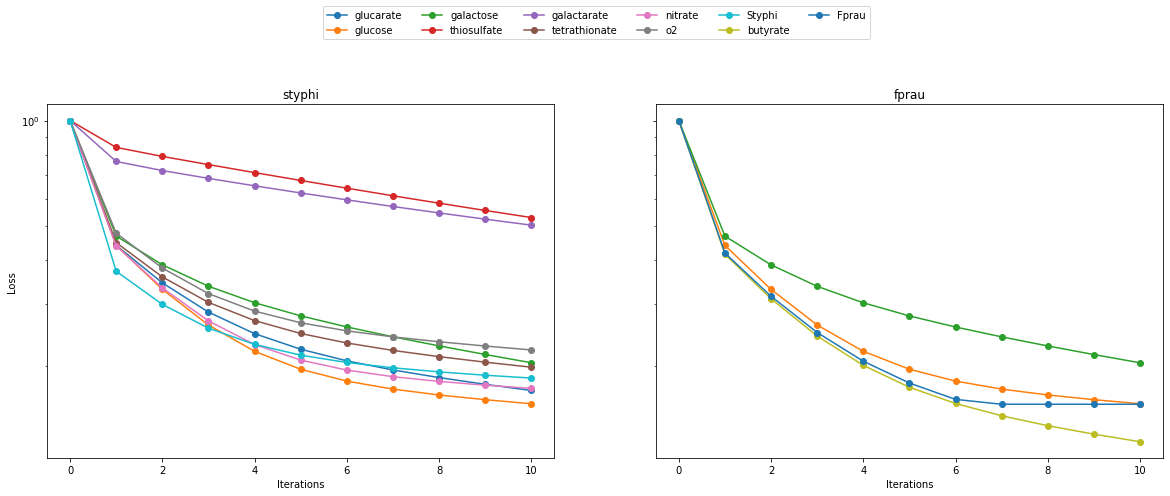

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6.5), sharey=True)
for k, s in enumerate(["styphi", "fprau"]):
    for j in range(mm[k].Ncompound):
        if mm[k].learning_loss[j][0]:
            axes[k].plot(mm[k].learning_loss[j], color=f'C{j}',
                         label=mm[k].compound_name[j],
                         marker='o')
        axes[k].set_yscale("log")
        axes[k].set_xlabel("Iterations")
        axes[k].set_title(s)
handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()
handles = handles1 + handles2[2:]
labels = labels1 + labels2[2:]
axes[0].set_ylabel("Loss")
fig.legend(handles, labels, ncol=6, bbox_to_anchor=(.7, 1.1))
#adapt_save_fig(fig, "loss.pdf")
plt.show()

In [34]:
mm[0].theta.shape, mm[0].theta_0

((100, 255, 11),
 array([-1.75745129, -1.00477238, -2.29685719, -1.19744377, -1.58929116,
        -1.87769379, -1.25354734, -0.96255156,  0.        ,  0.61336008,
         0.        ]))

In [35]:
[mm[i].save_results(f"data/samples_notebook/{s.lower()}_results.npz") for i,s in enumerate(exp.species)]

/home/simon/Documents/SVN_GIT/SLIMMEST/python-dfba-sampling/.tox/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


[None, None]

# 4- Running dFBA with metamodeled source term.

In [36]:
from dfba_sampling.metamodel import flux_metamodel_Wrapper
from dfba_sampling.utils import gen_dict_metamodel

Once the metamodels are trained, we just have to concatenate them into a dictionary and feed it 
to `TimeIntegration`.

In [37]:
dict_mm = gen_dict_metamodel(exp.species,
                             mm,
                             [f"data/samples_notebook/{s.lower()}_results.npz" for s in exp.species])

In [38]:
dict_mm

{'Styphi': <dfba_sampling.metamodel.Metamodel at 0x7f01f30548e0>,
 'Fprau': <dfba_sampling.metamodel.Metamodel at 0x7f020ac294c0>}

In [39]:
y_mm,flux_mm,constraint_mm=TimeIntegration(exp, RHS=flux_metamodel_Wrapper, dict_mm=dict_mm)

t= 0.0 / 11 hours
t= 1.0 / 11 hours


/home/simon/Documents/SVN_GIT/SLIMMEST/python-dfba-sampling/.tox/py39/lib/python3.9/site-packages/dfba_sampling/dFBA.py:117: RuntimeWarning: divide by zero encountered in true_divide
  1 - experiment.time_step * flux_fba[id_neg] / y[id_neg]


t= 2.0 / 11 hours
t= 3.0 / 11 hours
t= 4.0 / 11 hours
t= 5.0 / 11 hours
t= 6.0 / 11 hours
t= 7.0 / 11 hours
t= 8.0 / 11 hours
t= 9.0 / 11 hours
t= 10.0 / 11 hours
t= 11.0 / 11 hours


Simulation using metamodel:

In [40]:
Plot(y_mm, exp)

Simulation using FBA:

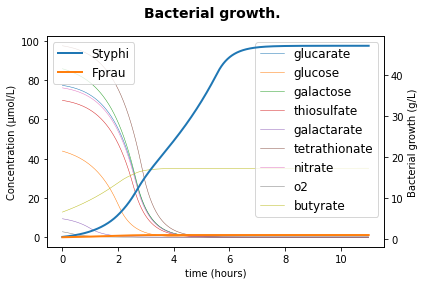

In [41]:
Plot(y_fba, exp)

Of course, we only trained for $10$ iterations on $100$ samples, but you get the idea.